<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

# setup

## libraries / mount google drive

In [126]:
import pandas as pd
import numpy as np
import sqlite3 as sql

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display, HTML

!pip install -U --quiet pandas-profiling category_encoders

import pandas_profiling
import category_encoders as ce

from google.colab import drive
drive.mount('drive')

random_state = 13

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## get the data

In [127]:
import sqlite3 as sql
import pandas as pd

db_file = '/content/drive/My Drive/android-21-12-primary.sqlite'
conn = sql.connect(db_file)

df_entries = pd.read_sql_query('SELECT entry, entry_rich FROM entries', conn)
# df_headwords = pd.read_sql_query('SELECT * FROM headwords', conn)
# df_thesaurus = pd.read_sql_query('SELECT * FROM thesaurus', conn)
# df_content_blocks = pd.read_sql_query('SELECT * FROM content_blocks', conn)
# df_headword_entries = pd.read_sql_query('SELECT * FROM headword_entries', conn)

print(f'entries: {df_entries.shape}')
# print(f'headwords: {df_headwords.shape}')
# print(f'thesaurus: {df_thesaurus.shape}')
# print(f'content_blocks: {df_content_blocks.shape}')
# print(f'headword_entries: {df_headword_entries.shape}')

entries: (148619, 2)


## engineer some features

In [0]:
# some functions to engineer features
def max_len_in_list(a_list):
  return max([len(item) for item in a_list])

In [163]:
X_train.columns

Index(['length', 'num_vowels', 'vowel_chunks', 'max_vowel_chunk_length',
       'num_ys', 'ends_in_y', 'num_consonants', 'consonant_chunks',
       'max_consonant_chunk_length'],
      dtype='object')

In [187]:
df_words[df_words['entry']=='disarticulate']['syllables']

131296    5
Name: syllables, dtype: int64

In [183]:
df_words[df_words['entry']=='disarticulate'][features]

,length,num_vowels,vowel_chunks,max_vowel_chunk_length,starts_with_vowel,ends_with_vowel,num_ys,ends_in_y,num_consonants,consonant_chunks,max_consonant_chunk_length
131296,13,6,6,1,False,False,0,False,7,6,2


In [185]:
# function to make a dataframe to predict an arbitrary word
def predict_word(word:str):
  word = pd.Series(word)
  data = {
      'length' : word.str.len(),
      'num_vowels' : word.str.count('[aeiou]'),
      'vowel_chunks' : word.str.count('[aeiou]+'),
      'max_vowel_chunk_length' : word.str.split('[^aeiou]+').apply(lambda a_list : max([len(item) for item in a_list])),
      'starts_with_vowel' : word.str.startswith('[aeiou]'),
      'ends_with_vowel' : word.str.endswith('[aeiou]'),
      'num_ys' : word.str.count('y'), 
      'ends_in_y' : word.str.endswith('y'), 
      'num_consonants' : word.str.count('[^aeiou]'), 
      'consonant_chunks' : word.str.count('[^aeiou]+'),
      'max_consonant_chunk_length' : word.str.split('[aeiou]+').apply(lambda a_list : max([len(item) for item in a_list]))
  }
  return pd.DataFrame(data)

predict_word('disarticulate')

,length,num_vowels,vowel_chunks,max_vowel_chunk_length,starts_with_vowel,ends_with_vowel,num_ys,ends_in_y,num_consonants,consonant_chunks,max_consonant_chunk_length
0,13,6,6,1,False,False,0,False,7,6,2


In [171]:
# select entries that are lower case, only contain letters, and have at least 3 characters
df_words = df_entries[df_entries['entry'].str.match('^[a-z]{3,}$', case=False)].copy()

# drop entries with no vowels or y's
no_vowelys = ~df_words['entry'].str.contains('[aeiouy]')
df_words.drop(no_vowelys[no_vowelys == True].index, inplace=True)

# fix some errors i found
df_words.loc[df_words['entry']=='finasteride', 'entry_rich'] = chr(183).join(['fin', 'as', 'ter', 'ide'])
df_words.loc[df_words['entry']=='subnuclear', 'entry_rich'] = chr(183).join(['sub', 'nu', 'cle', 'ar'])
df_words.loc[df_words['entry']=='omeprazole', 'entry_rich'] = chr(183).join(['o', 'me', 'pra', 'zole'])
df_words.loc[df_words['entry']=='protocal', 'entry_rich'] = chr(183).join(['pro', 'to', 'cal'])

# create feature 'length'
df_words['length'] = df_words['entry'].str.len()

# create feature 'syllables'
df_words['syllables'] = df_words['entry_rich'].str.split(chr(183)).str.len()

# create vowel related features
#  'num_vowels' - total occurences of 'a', 'e', 'i', 'o', and 'u'
#  'vowel_chunks' - total occurences of sequential vowels (includes y)
#  'max_vowel_chunk_length' - length of longest vowel sequence
df_words['num_vowels'] = df_words['entry'].str.count('[aeiou]')
df_words['vowel_chunks'] = df_words['entry'].str.count('[aeiouy]+')
df_words['max_vowel_chunk_length'] = df_words['entry'].str.split('[^aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))
df_words['starts_with_vowel'] = df_words['entry'].str.startswith('[aeiou]')
df_words['ends_with_vowel'] = df_words['entry'].str.endswith('[aeiou]')

# create features to account for the character 'y'
#  'num_ys' - total occurences of 'y'
#  'ends_in_y' - ends in 'y'
df_words['num_ys'] = df_words['entry'].str.count('y')
df_words['ends_in_y'] = df_words['entry'].str.endswith('y')

# create features accounting for consonants
#  'num_consonants' - total occurences of not 'a', 'e', 'i', 'o', and 'u'
#  'consonant_chunks' - total occurences of sequential consonants (excludes y)
#  'max_consonant_chunk_length' - length of longest consonant sequence
df_words['num_consonants'] = df_words['entry'].str.count('[^aeiou]')
df_words['consonant_chunks'] = df_words['entry'].str.count('[^aeiouy]+')
df_words['max_consonant_chunk_length'] = df_words['entry'].str.split('[aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))

df_words.shape

(92404, 14)

In [172]:
df_words

,entry,entry_rich,length,syllables,num_vowels,vowel_chunks,max_vowel_chunk_length,starts_with_vowel,ends_with_vowel,num_ys,ends_in_y,num_consonants,consonant_chunks,max_consonant_chunk_length
42,Aachen,Aa·chen,6,2,2,2,1,False,False,0,False,4,3,2
49,aah,aah,3,1,2,1,2,False,False,0,False,1,1,1
50,Aalborg,Aal·borg,7,2,2,2,1,False,False,0,False,5,3,2
51,Aalesund,Aa·le·sund,8,3,3,3,1,False,False,0,False,5,4,2
52,aalii,aa·li·i,5,3,4,2,2,False,False,0,False,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148613,glazer,glaz·er,6,2,2,2,1,False,False,0,False,4,3,2
148614,Glazer,Gla·zer,6,2,2,2,1,False,False,0,False,4,3,2
148615,glazier,gla·zier,7,2,3,2,2,False,False,0,False,4,3,2
148617,glaziery,gla·zier·y,8,3,3,3,2,False,False,1,True,5,3,2


# Assignment

## Choose your target. 

Which column in your tabular dataset will you predict?

In [0]:
target = 'syllables'

## Is your problem regression or classification?


I am leaning towards classification right now. I do not think regression applies because there is not an infinite number of possibilities.

Having chosen classification, it looks as though I will need to group them instead of prediting a discrete number.

## How is your target distributed?

Classification: How many classes? Are the classes imbalanced?

Regression: Is the target right-skewed? If so, you may want to log transform the target.


In [136]:
df_words[target].value_counts()

2     24369
3     20198
4     12451
1      7771
5      5520
6      1612
7       439
8       105
9        22
10       10
12        2
11        2
19        1
14        1
Name: syllables, dtype: int64

In [162]:
df_words[target].value_counts()

2     33078
3     26552
4     14936
1      9547
5      6031
6      1673
7       444
8       105
9        22
10       10
12        2
11        2
19        1
14        1
Name: syllables, dtype: int64

In [137]:
df_words[target].value_counts(normalize=True)

2     0.336110
3     0.278582
4     0.171731
1     0.107182
5     0.076135
6     0.022234
7     0.006055
8     0.001448
9     0.000303
10    0.000138
12    0.000028
11    0.000028
19    0.000014
14    0.000014
Name: syllables, dtype: float64

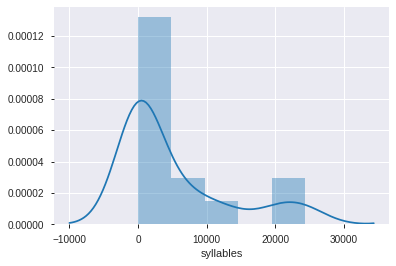

In [138]:
sns.distplot(df_words[target].value_counts());

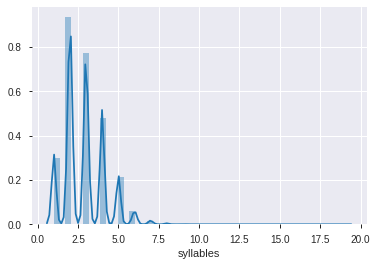

In [139]:
sns.distplot(df_words[target]);

In [140]:
t = df_words[target].copy()
t[t>=6] = 6
t.value_counts()

2    24369
3    20198
4    12451
1     7771
5     5520
6     2194
Name: syllables, dtype: int64

In [141]:
t.value_counts(normalize=True).sort_index()

1    0.107182
2    0.336110
3    0.278582
4    0.171731
5    0.076135
6    0.030261
Name: syllables, dtype: float64

In [142]:
t.astype(str).str.replace('6', '6+').value_counts()

2     24369
3     20198
4     12451
1      7771
5      5520
6+     2194
Name: syllables, dtype: int64

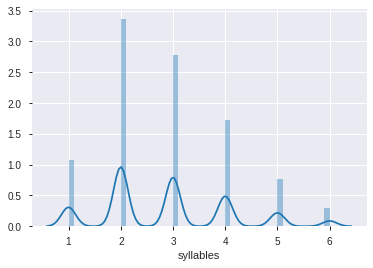

In [143]:
sns.distplot(t);

In [144]:
tt = df_words[target].copy()
tt[tt >= 6] = 6
tt[tt <= 2] = 2
tt[(tt > 2) & (tt < 6)] = 3
ttt = tt.astype(str).str.replace('2', '1-2').str.replace('3', '3-5').str.replace('6', '6+')
tt.value_counts()

3    38169
2    32140
6     2194
Name: syllables, dtype: int64

In [145]:
tt.value_counts(normalize=True)

3    0.526447
2    0.443292
6    0.030261
Name: syllables, dtype: float64

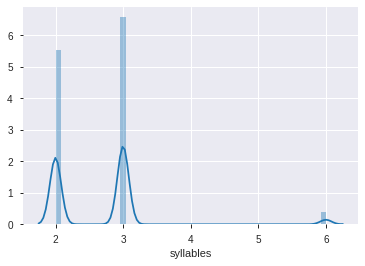

In [146]:
sns.distplot(tt);

In [174]:
def group_syllables(syllables):
  if syllables <= 2:
    return '1-2'
  elif syllables <= 5:
    return '3-5'
  else:
    return '6+'

df_words['syllables_group'] = df_words['syllables'].apply(group_syllables)
df_words

,entry,entry_rich,length,syllables,num_vowels,vowel_chunks,max_vowel_chunk_length,starts_with_vowel,ends_with_vowel,num_ys,ends_in_y,num_consonants,consonant_chunks,max_consonant_chunk_length,syllables_group
42,Aachen,Aa·chen,6,2,2,2,1,False,False,0,False,4,3,2,1-2
49,aah,aah,3,1,2,1,2,False,False,0,False,1,1,1,1-2
50,Aalborg,Aal·borg,7,2,2,2,1,False,False,0,False,5,3,2,1-2
51,Aalesund,Aa·le·sund,8,3,3,3,1,False,False,0,False,5,4,2,3-5
52,aalii,aa·li·i,5,3,4,2,2,False,False,0,False,1,1,1,3-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148613,glazer,glaz·er,6,2,2,2,1,False,False,0,False,4,3,2,1-2
148614,Glazer,Gla·zer,6,2,2,2,1,False,False,0,False,4,3,2,1-2
148615,glazier,gla·zier,7,2,3,2,2,False,False,0,False,4,3,2,1-2
148617,glaziery,gla·zier·y,8,3,3,3,2,False,False,1,True,5,3,2,3-5


In [175]:
target = 'syllables_group'
df_words[target].value_counts(normalize=True)

3-5    0.514253
1-2    0.461290
6+     0.024458
Name: syllables_group, dtype: float64

## Choose your evaluation metric(s).

Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?

Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?


In [0]:
from sklearn.metrics import accuracy_score

## Choose which observations you will use to train, validate, and test your model.

Are some observations outliers? Will you exclude them?

Will you do a random split or a time-based split?


In [189]:
from sklearn.model_selection import train_test_split

df_train_not_split, df_test = train_test_split(df_words, random_state=random_state)#, stratify=df_words[target])
df_train, df_val = train_test_split(df_train_not_split, random_state=random_state)#, stratify=df_train_not_split[target])

df_train.shape, df_val.shape, df_test.shape

((51977, 15), (17326, 15), (23101, 15))

## Begin to clean and explore your data.


## Begin to choose which features, if any, to exclude. 

Would some features "leak" future information?

In [190]:
df_train.columns

Index(['entry', 'entry_rich', 'length', 'syllables', 'num_vowels',
       'vowel_chunks', 'max_vowel_chunk_length', 'starts_with_vowel',
       'ends_with_vowel', 'num_ys', 'ends_in_y', 'num_consonants',
       'consonant_chunks', 'max_consonant_chunk_length', 'syllables_group'],
      dtype='object')

In [191]:
# features = ['length', 'num_vowels', 'vowel_chunks', 'num_ys', 'ends_in_y', 'num_consonants', 'consonant_chunks']

features = df_train.columns.drop(['entry', 'entry_rich', 'syllables', 'syllables_group'])
print('features:', features)

X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

features: Index(['length', 'num_vowels', 'vowel_chunks', 'max_vowel_chunk_length',
       'starts_with_vowel', 'ends_with_vowel', 'num_ys', 'ends_in_y',
       'num_consonants', 'consonant_chunks', 'max_consonant_chunk_length'],
      dtype='object')


((51977, 11), (17326, 11), (23101, 11), (51977,), (17326,), (23101,))

In [192]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    RandomForestClassifier(random_state=random_state, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_val, y_val)

print(f'Validation score: {score*100:.2f}%')

Validation score: 75.09%


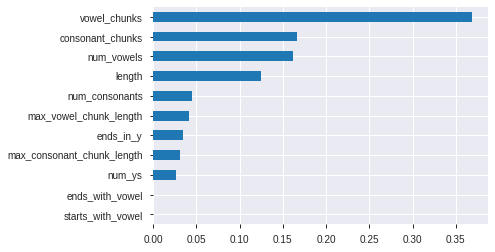

In [193]:
model = pipeline.named_steps['randomforestclassifier']

feature_names = X_train.columns
importances = pd.Series(model.feature_importances_, feature_names)

importances.sort_values().plot.barh();

In [201]:
test_sample = df_test.sample(1)[['entry', 'syllables']]
test_sample['predicted'] = pipeline.predict(predict_word(test_sample['entry']))
test_sample

,entry,syllables,predicted
116979,chalcophile,3,4


In [155]:
from sklearn.linear_model import LogisticRegression

pipeline = make_pipeline(
    LogisticRegression(random_state=random_state, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_val, y_val)

print(f'Logistic Regression validation accuracy: {score*100:.2f}%')

Logistic Regression validation accuracy: 90.51%


length                       -0.696826
num_vowels                   -0.961458
vowel_chunks                 -1.456445
max_vowel_chunk_length        0.190066
num_ys                       -2.030538
ends_in_y                    -0.803682
num_consonants                0.264631
consonant_chunks             -0.416026
max_consonant_chunk_length    0.463077
dtype: float64

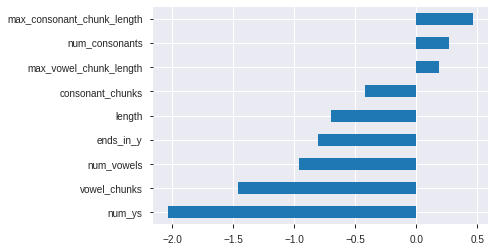

In [156]:
model = pipeline.named_steps['logisticregression']

coefficients = pd.Series(model.coef_[0], feature_names)
coefficients.sort_values().plot.barh();
coefficients

In [157]:
y_train = df_train['syllables']
y_val = df_val['syllables']

from sklearn.linear_model import LinearRegression

pipeline = make_pipeline(
    LinearRegression(n_jobs=-1)
)

pipeline.fit(X_train, y_train)
score = pipeline.score(X_val, y_val)

print(f'Linear Regression validation score: {score*100:.2f}%')

y_pred = pipeline.predict(X_val).round().astype(int)

print(f'Linear Regression rounded accuracy: {accuracy_score(y_val, y_pred)}')

from sklearn.metrics import mean_absolute_error, mean_squared_error

print(f'Linear Regression mea: {mean_absolute_error(y_val, y_pred)}')
print(f'Linear Regression rmse: {np.sqrt(mean_squared_error(y_val, y_pred))}')


Linear Regression validation score: 86.59%
Linear Regression rounded accuracy: 0.7352703199705775
Linear Regression mea: 0.2701728576682604
Linear Regression rmse: 0.5302889079125583


length                        0.127301
num_vowels                    0.127301
vowel_chunks                  0.127301
max_vowel_chunk_length        0.127301
num_ys                        0.127301
ends_in_y                     0.127301
num_consonants                0.127301
consonant_chunks              0.127301
max_consonant_chunk_length    0.127301
dtype: float64

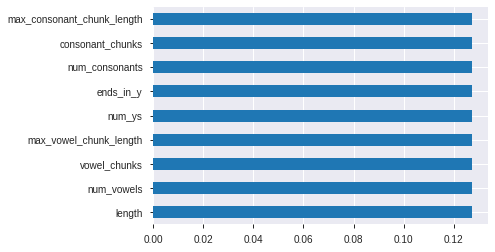

In [158]:
model = pipeline.named_steps['linearregression']

coefficients = pd.Series(model.coef_[0], feature_names)
coefficients.sort_values().plot.barh();
coefficients

In [80]:
y_pred

array([2.58135454, 1.8870186 , 1.72490923, ..., 2.68633501, 2.20879594,
       2.04766313])

In [86]:
y_pred.round().astype(int)

array([3, 2, 2, ..., 3, 2, 2])

In [125]:
y_pred = [df_words['syllables'].mode()[0]] * len(df_words)

print(f"baseline mea: {mean_absolute_error(df_words['syllables'], y_pred)}")
print(f"baseline rmse: {np.sqrt(mean_squared_error(df_words['syllables'], y_pred))}")
print(f"baseline accuracy: {accuracy_score(df_words['syllables'], y_pred)}")


baseline mea: 1.0896790477635407
baseline rmse: 1.533559953885093
baseline accuracy: 0.3361102299215205
